<a href="https://colab.research.google.com/github/rogerthatroach/Roach/blob/master/kerasCNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, TimeDistributed, Bidirectional, GRU
from keras.optimizers import RMSprop, adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


#sns.set(style='white', context='notebook', palette='deep')

In [0]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")

In [0]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1)

del train

In [84]:
print("Missing values in training data:", X_train.isnull().sum().any())
print("Missing values in test data:", test.isnull().sum().any())

Missing values in training data: False
Missing values in test data: False


In [0]:
X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Y_train = to_categorical(Y_train, num_classes = 10)

In [0]:
random_seed = 100
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed)

In [0]:
#g = plt.imshow(X_train[0][:,:,0])

In [88]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1), name = "CONV_1"))
model.add(BatchNormalization(name = "BN_1"))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', name = "CONV_2"))
model.add(BatchNormalization(name = "BN_2"))
model.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_1"))
model.add(Dropout(0.20, name = "DROP_1"))


model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 activation ='relu', name = "CONV_3"))
model.add(BatchNormalization(name = "BN_3"))
model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 activation ='relu', name = "CONV_4"))
model.add(BatchNormalization(name = "BN_4"))
model.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_2"))
model.add(Dropout(0.20, name = "DROP_2"))

model.add(Flatten(name = "FLAT_1"))
model.add(Dense(128, activation = "relu", name = "FC_1"))
model.add(BatchNormalization(name = "BN_5"))
model.add(Dropout(0.20, name = "DROP_3"))
model.add(Dense(10, activation = "softmax", name = "FC_2"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
CONV_2 (Conv2D)              (None, 28, 28, 32)        25632     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
MAXPOOL_1 (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
DROP_1 (Dropout)             (None, 14, 14, 32)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 12, 12, 64)        18496     
__________

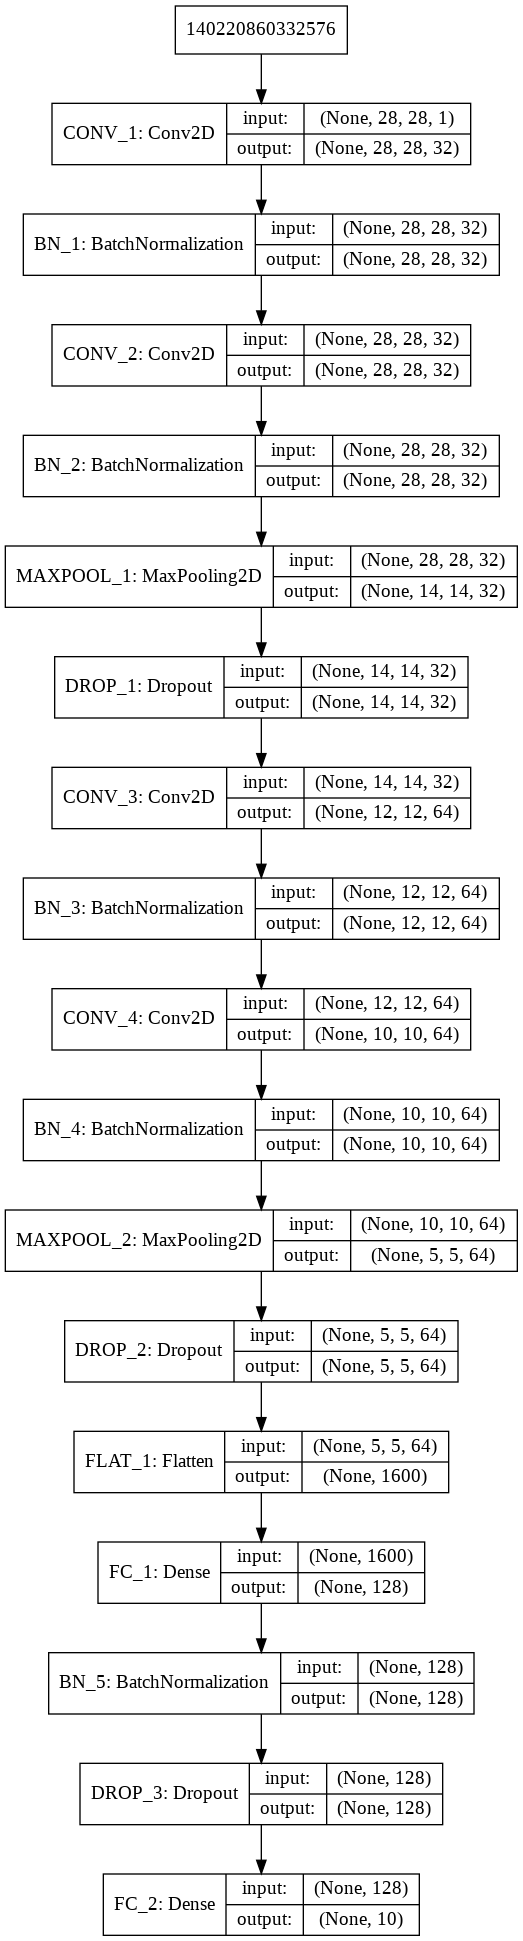

In [89]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [0]:
optimizer = adam(lr = 0.001, epsilon = 1e-08, decay = 0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
callbacks = [
    EarlyStopping(
        monitor = 'val_acc', 
        patience = 10,
        mode = 'max',
        verbose = 1),
    ReduceLROnPlateau(
        monitor = 'val_acc', 
        patience = 3, 
        verbose = 1, 
        factor = 0.5, 
        min_lr = 0.00001)]

In [0]:
epochs = 50
batch_size = 86

In [0]:
datagen = ImageDataGenerator(
        rotation_range = 10, 
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1)  

datagen.fit(X_train)

In [94]:
history = model.fit_generator(datagen.flow(X_train, 
                                           Y_train, 
                                           batch_size = batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,Y_val),
                              verbose = 1, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks = callbacks)

Epoch 1/50
439/439 [==============================] - 22s 50ms/step - loss: 0.2973 - acc: 0.9068 - val_loss: 0.0575 - val_acc: 0.9831
Epoch 2/50
439/439 [==============================] - 18s 40ms/step - loss: 0.0968 - acc: 0.9698 - val_loss: 0.0654 - val_acc: 0.9793
Epoch 3/50
439/439 [==============================] - 18s 41ms/step - loss: 0.0746 - acc: 0.9768 - val_loss: 0.0393 - val_acc: 0.9881
Epoch 4/50
439/439 [==============================] - 18s 41ms/step - loss: 0.0615 - acc: 0.9815 - val_loss: 0.0320 - val_acc: 0.9898
Epoch 5/50
439/439 [==============================] - 18s 41ms/step - loss: 0.0522 - acc: 0.9842 - val_loss: 0.0284 - val_acc: 0.9902
Epoch 6/50
439/439 [==============================] - 18s 41ms/step - loss: 0.0504 - acc: 0.9844 - val_loss: 0.0342 - val_acc: 0.9883
Epoch 7/50
439/439 [==============================] - 18s 41ms/step - loss: 0.0454 - acc: 0.9861 - val_loss: 0.0306 - val_acc: 0.9914
Epoch 8/50
439/439 [==============================] - 18s 41ms

In [0]:
results = model.predict(test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name = "Label")

In [0]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results], axis = 1)

submission.to_csv("cnn_mnist_datagen5.csv", index = False)

In [19]:
pwd

'/content'